<a href="https://colab.research.google.com/github/Nancy0627/Pneumonia-detection/blob/main/IDBMS_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import glob
from tqdm.notebook import tqdm
import albumentations as A
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

# Loading Data


In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url='https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'
data=od.download(dataset_url)
dataset_dir='/content/chest-xray-pneumonia/chest_xray/test'
len(os.listdir(dataset_dir))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saswatabasu
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:14<00:00, 168MB/s]


2

In [ ]:
path='/content/chest-xray-pneumonia'
train_data = glob.glob('/content/chest-xray-pneumonia/chest_xray/train/**/*.jpeg')
test_data = glob.glob('/content/chest-xray-pneumonia/chest_xray/test/**/*.jpeg')
val_data = glob.glob('/content/chest-xray-pneumonia/chest_xray/val/**/*.jpeg')
print("〰"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("〰"*20)
DIR = "/content/chest-xray-pneumonia/chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []
for cat in sets:
  path = os.path.join(DIR, cat)
  norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
  pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
  all_normal.extend(norm)
  all_pneumonia.extend(pneu)
  print("〰"*20)
  print(f"Total Pneumonia Images: {len(all_pneumonia)}")
  print(f"Total Normal Images: {len(all_normal)}")
  print("〰"*20)


〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 3875
Total Normal Images: 1341
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4265
Total Normal Images: 1575
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4273
Total Normal Images: 1583
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰



# Plot charts for Class distribution

In [ ]:
labels = ["Normal",'Pneumonia ']
values = [len(all_normal), len(all_pneumonia)]
colors = ['green', 'pink']
fig = go.Figure(data=[go.Pie(labels=labels,values=values,hole=.5)])
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Image Category Distribution",
titlefont={'size': 30},)
iplot(fig)

# Shuffle images randomly

In [ ]:
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]


# Viewing Images in X-Ray

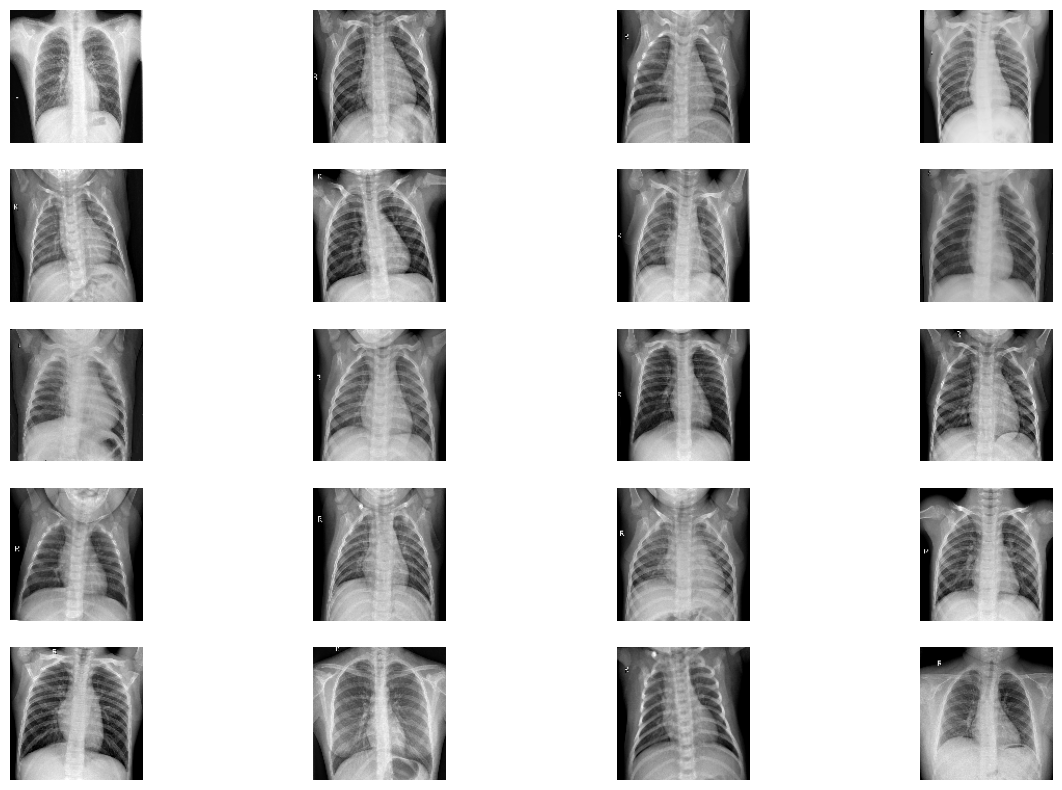

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)



# Convert to Grayscale then apply Gaussian Blur
Gaussian filters have the properties of having no overshoot to a step function input while minimizing the rise and fall time. In terms of image processing, any sharp edges in images are smoothed while minimizing too much blurring. OpenCV provides cv2.gaussianblur() function to apply Gaussian Smoothing on the input source image. Following is the syntax
of GaussianBlur() function :

In [ ]:
# dst = cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])

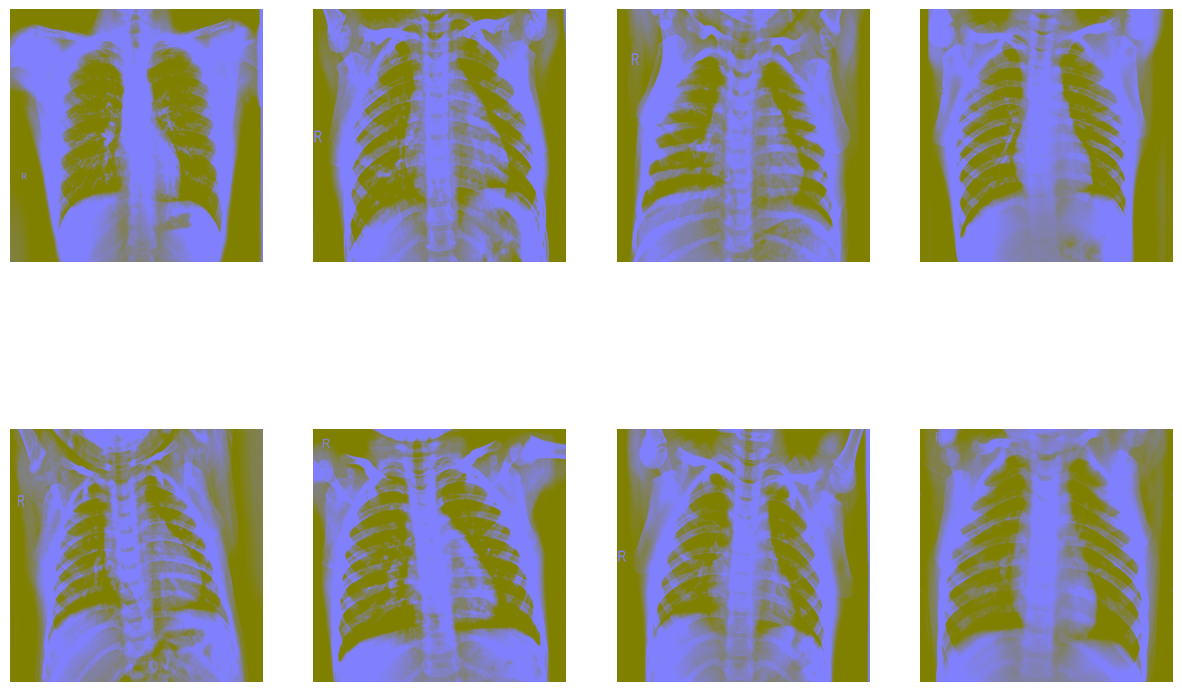

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

# Fourier Method for viewing pixel distributions
Fourier Transform is used to analyze the frequency characteristics of various filters. For images, 2D
Discrete Fourier Transform (DFT) is used to find the frequency domain. A fast algorithm called Fast
Fourier Transform (FFT) is used for calculation of DFT. Numpy has an FFT package to do
this. np.fft.fft2() provides us the frequency transform which will be a complex array. Its first argument is
the input image, which is grayscale. Second argument is optional which decides the size of output array. If
it is greater than size of input image, input image is padded with zeros before calculation of FFT. If it is less
than input image, input image will be cropped. If no arguments passed, Output array size will be same as
input.

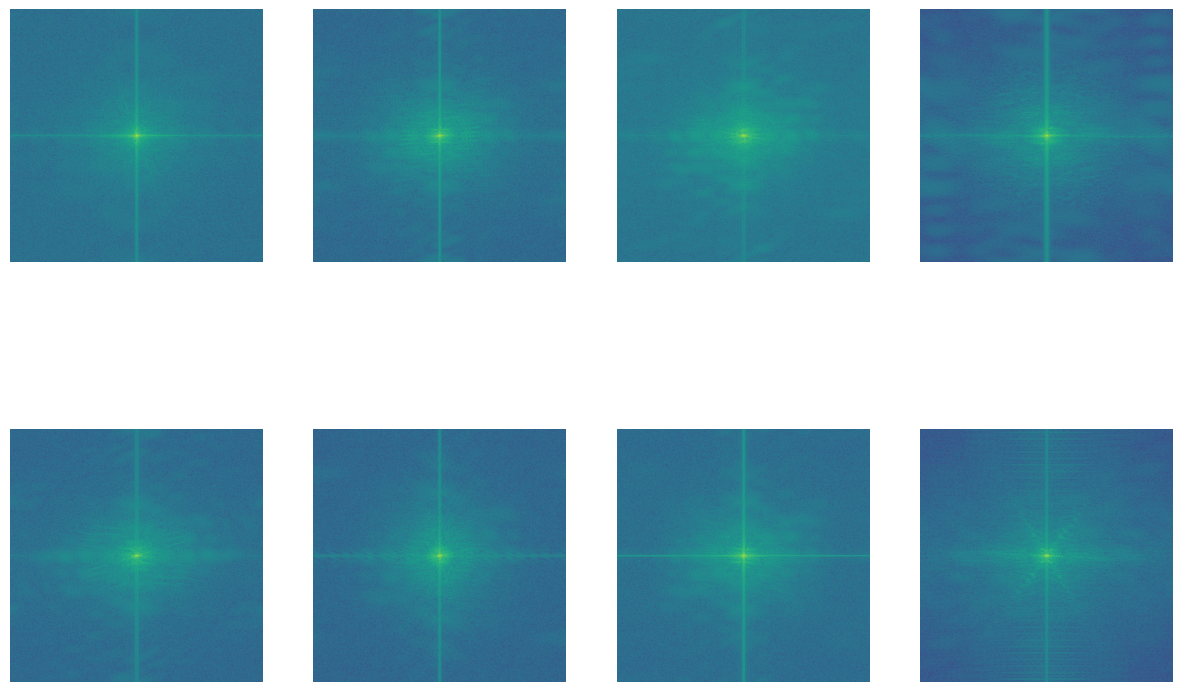

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

# Image Erosion
Erosion and Dilation are morphological image processing operations.
OpenCV morphological image processing is a procedure for modifying the geometric structure in the image. In morphism, we find the shape and size or structure of an object. Both operations are defined for binary images, but we can also use them on a grayscale image. These are widely used in the following way:
1. Removing Noise
2. Identify intensity bumps or holes in the picture.
3. Isolation of individual elements and joining disparate elements in image.

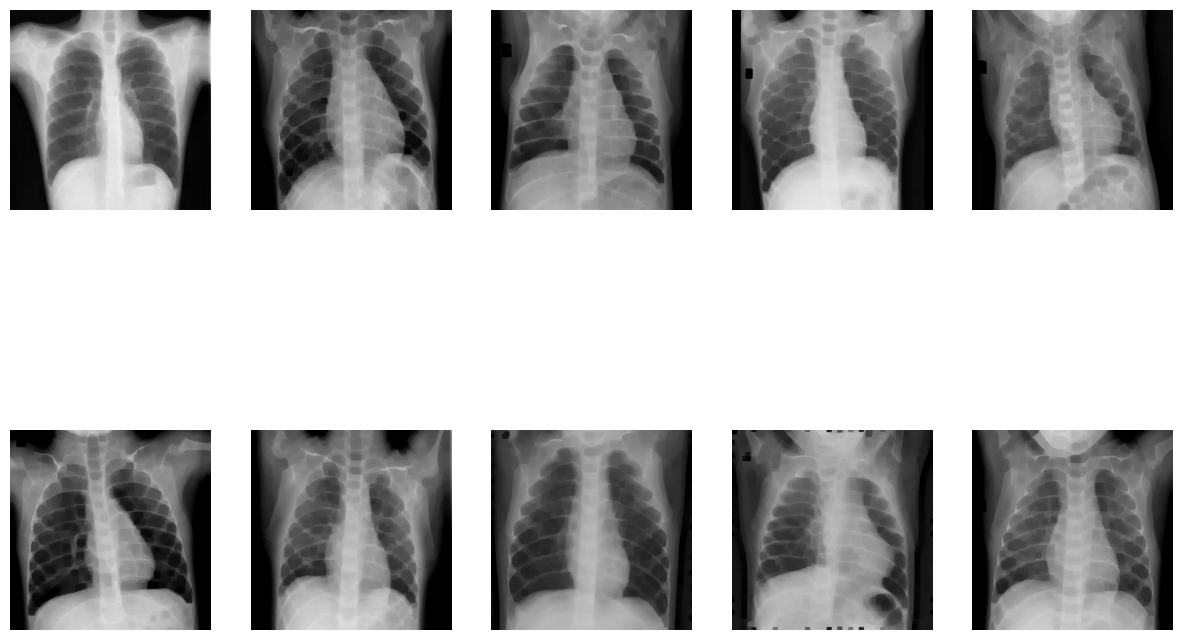

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 5;
rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

# Dilation of Images
Dilation is a technique where we expand the image. It adds the number of pixels to the
boundaries of objects in an image. The structuring element controls it. The structuring element
is a matrix of 1's and 0's. The dilation operation is performed by using
the cv2.dilate() method. The syntax is given below:
cv2.dilate(src, dst, kernel)

Parameters: The dilate() function accepts the following argument:

1. src - It represents the input image.
2. dst - It represents the output image.
3. kernel - It represents the kernel.

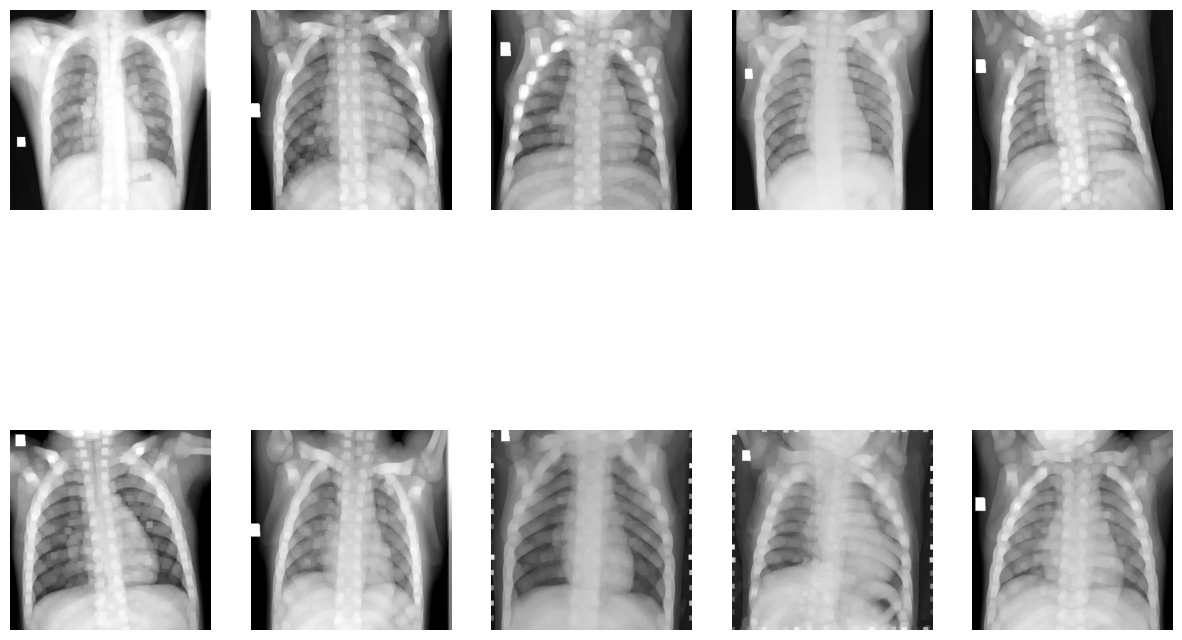

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 5;
rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

# Canny Edge Detection for Segmentation
The Canny edge detector is arguably the most well-known and the most used edge detector in all of computer vision and image processing. While the Canny edge detector is not exactly “trivial” to understand, we’ll break down the steps into bite-sized pieces so we can understand what is going on under the hood. Fortunately for us, since the Canny edge detector is so widely used in almost all computer vision applications, OpenCV has already implemented it for us in the cv.Canny() function.

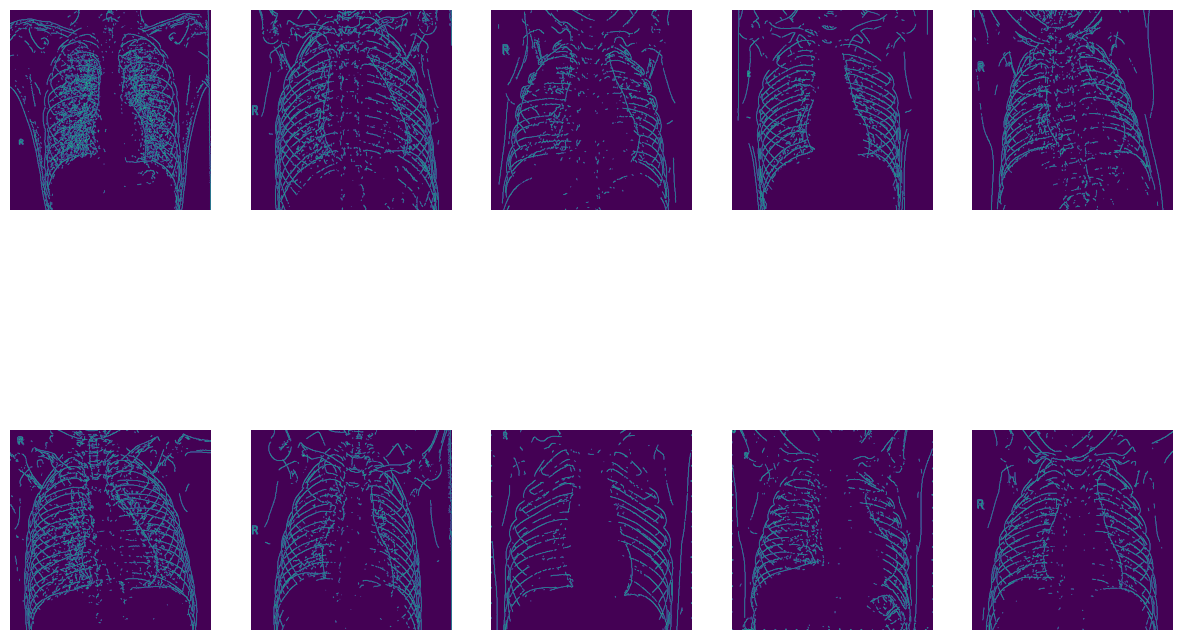

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

# Building Machine Learning Model for Pneumonia Detection
# Divide data to create a training and validation set using the Keras Image Data Generator with Image Enhancement

In [ ]:
train_gen = ImageDataGenerator( rescale=1/255., horizontal_flip=True, vertical_flip=False, rotation_range=0.3, zoom_range=0.4)
val_gen = ImageDataGenerator(rescale=1/255., horizontal_flip=True, vertical_flip=False, rotation_range=0.3, zoom_range=0.4)
Train = train_gen.flow_from_directory(  "/content/chest-xray-pneumonia/chest_xray/train",batch_size=16, target_size=(224, 224),class_mode="binary")
Val = train_gen.flow_from_directory(   "/content/chest-xray-pneumonia/chest_xray/val",batch_size=8,target_size=(224, 224),class_mode="binary" )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.



# Convolution Neural Network Architecture

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

# Model Compilation

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training fit_generator() instead of fit() because we are going to take the train data from the train_gen object.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size and image size
batch_size = 32
img_size = (224, 224)

# Create the training and validation data generators
train_generator = train_datagen.flow_from_directory(
    '/content/chest-xray-pneumonia/chest_xray/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/chest-xray-pneumonia/chest_xray/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the early stopping callback
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping_cb]
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/15
163/163 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.7975

163/163 [==============================] - 130s 683ms/step - loss: 0.4508 - accuracy: 0.7975
Epoch 2/15
163/163 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.8669

163/163 [==============================] - 109s 665ms/step - loss: 0.2983 - accuracy: 0.8669
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8802

163/163 [==============================] - 116s 713ms/step - loss: 0.2764 - accuracy: 0.8802
Epoch 4/15
163/163 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.8951

163/163 [==============================] - 108s 665ms/step - loss: 0.2585 - accuracy: 0.8951
Epoch 5/15
163/163 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9030

163/163 [==============================] - 108s 664ms/step - loss: 0.2450 - accuracy: 0.9030
Epoch 6/15
163/163 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9080

163/163 [==============================] - 109s 667ms/step - loss: 0.2239 - accuracy: 0.9080
Epoch 7/15
163/163 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9201

163/163 [==============================] - 109s 668ms/step - loss: 0.2085 - accuracy: 0.9201
Epoch 8/15
163/163 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9135

163/163 [==============================] - 109s 669ms/step - loss: 0.2105 - accuracy: 0.9135
Epoch 9/15
163/163 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9141

163/163 [==============================] - 108s 662ms/step - loss: 0.2090 - accuracy: 0.9141
Epoch 10/15
163/163 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9243

163/163 [==============================] - 109s 667ms/step - loss: 0.1999 - accuracy: 0.9243
Epoch 11/15
163/163 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9277

163/163 [==============================] - 110s 672ms/step - loss: 0.1839 - accuracy: 0.9277
Epoch 12/15
163/163 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.9365

163/163 [==============================] - 110s 676ms/step - loss: 0.1706 - accuracy: 0.9365
Epoch 13/15
163/163 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9375

163/163 [==============================] - 110s 675ms/step - loss: 0.1645 - accuracy: 0.9375
Epoch 14/15
163/163 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9314

163/163 [==============================] - 110s 672ms/step - loss: 0.1737 - accuracy: 0.9314
Epoch 15/15
163/163 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9369

163/163 [==============================] - 109s 669ms/step - loss: 0.1641 - accuracy: 0.9369


# Visualization of model performance

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(
    '/content/chest-xray-pneumonia/chest_xray/test',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)

predictions = model.predict(test_data, steps=np.ceil(test_data.samples / test_data.batch_size))


Found 624 images belonging to 2 classes.
78/78 [==============================] - 6s 65ms/step


In [ ]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count):
        num = i if sample else random.randint(0, length-1)
        while num in m:
            num = random.randint(0, length-1)
        m[num]=1
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"\\"+ file_names[num], 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)
        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

figure_directory="/content/chest-xray-pneumonia/chest_xray/"

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    figure_directory+"/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [ ]:
image_file_name_batch = figure_directory + "/train"
image_file_name_sample = figure_directory + "/test"
batch_size_t = 32
class_map = {v: k for k, v in test_generator.class_indices.items()}
dpi = 100
ncols = 8
nrows = 4
count = ncols * nrows

In [ ]:
def get_reset_subplot_params(nrows, ncols, dpi):
    return {
        "nrows": nrows,
        "ncols": ncols,
        "figsize": (ncols * 3, nrows * 3),
        "dpi": dpi,
        "hspace": 0.3,
        "wspace": 0.2
    }

In [ ]:
def get_reset_plot_params(nrows, ncols, dpi):
  return {
        "nrows": nrows,
        "ncols": ncols,
        "figsize": (ncols * 3, nrows * 3),
        "dpi": dpi,
        "hspace": 0.3,
        "wspace": 0.2
    }

In [ ]:
subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params(nrows,ncols,dpi)

In [ ]:
# show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=32, sample)

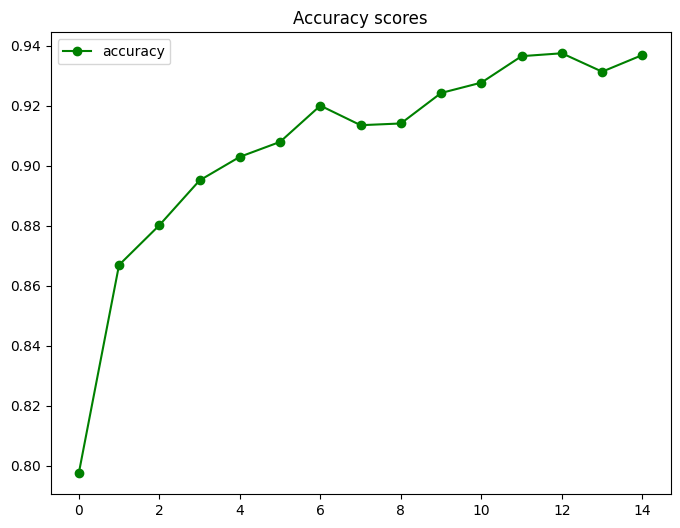

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'],'go-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


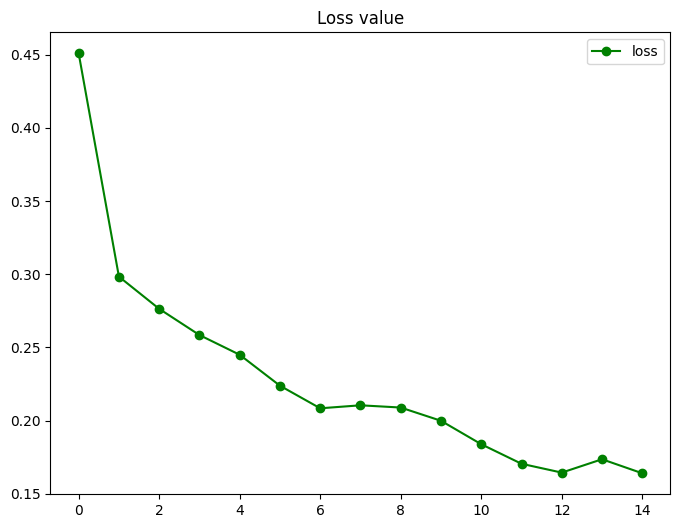

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'],'go-')
plt.legend(['loss', 'val_loss'])
plt.show()